In [27]:
import pandas as pd
import numpy as np
import geopandas as gpd
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [14]:
def loadData(file):
    data = pd.read_csv(file)
    print('Raw shape: ',data.shape)
    data['Date'] = pd.to_datetime(data.Date)
    print('Days: ',len(set(data.Date)))
    return data
def getTimeSeries(df,zones):
    df = df.loc[df['DOLocationID'].isin(zones)]
    table = pd.pivot_table(df, values='vehicle_count', index=['Date'],
                    columns=['DOLocationID','Hour'], aggfunc=np.sum, fill_value=0)
#     table.columns = [i[1] for i in table.columns]
    missing_columns = [i for i in zones if i not in table.columns]
    for col in missing_columns:
        table[col] = 0
    table = table[sorted(table.columns)]
    return table

In [15]:
zone = gpd.read_file('../../Data/NYC Taxi Zones.geojson')
zones = zone['location_id'].unique()
zones = [int(i) for i in zones]

In [16]:
hub = 'JFK'
pca_comps = 6
dataDir = '/home/mingyi/Dropbox/UrbanTemporalNetworks/processedData/'
file = dataDir + hub + 'VehicleByHour2019fromHub.csv'

In [17]:
real = loadData(file)
real = getTimeSeries(real,zones)
real.head()

Raw shape:  (2295120, 4)
Days:  365


DOLocationID 1                               ... 263                          \
Hour          0  1  2  3  4  5  6  7  8  9   ...  14  15  16  17  18  19  20   
Date                                         ...                               
2019-01-01     1  0  0  0  1  0  1  2  1  3  ...  23  16  18  13  17  20  25   
2019-01-02     0  1  0  0  1  1  1  0  3  1  ...  12  15  13  16  18  18  19   
2019-01-03     0  1  1  1  1  1  2  2  1  4  ...   5   4  13  11  14   6   9   
2019-01-04     2  0  1  1  1  0  0  0  1  2  ...   3   5   6  11   9  11  18   
2019-01-05     0  0  0  0  2  0  1  2  1  3  ...   5   4   8   9   8  14  19   

DOLocationID              
Hour          21  22  23  
Date                      
2019-01-01    32  13  20  
2019-01-02    16  20  19  
2019-01-03    12  16  15  
2019-01-04    19  10   8  
2019-01-05    15  13  12  

[5 rows x 6194 columns]

In [62]:
scaler = StandardScaler()
realS = scaler.fit_transform(realS)
pca = PCA(n_components=365)
pca.fit(realS)
explained_variance = pca.explained_variance_ratio_

In [63]:
for i,j in enumerate(explained_variance.cumsum()):
    if j > 0.85:
        print(i)
        break

266


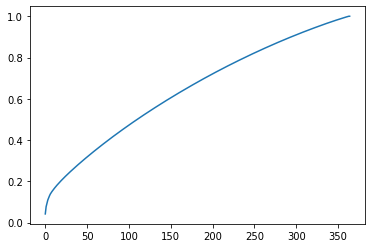

In [64]:
plt.plot(range(0,365),explained_variance.cumsum())

In [65]:
pca = PCA(n_components=266)
pc = pca.fit_transform(realS)

In [67]:
def GMMBIC(matrix):
    bic = []
    for ncomp in range(2,10):
        gm=GaussianMixture(n_components=ncomp,n_init=100,max_iter=1000,random_state=0)
        labels = gm.fit_predict(matrix)
        score = gm.bic(matrix)
        bic += [score]
#         print(ncomp,score)
#     print('------------------------')
    GMMComp = np.array(bic).argmin() + 2
#         GMMBIC = np.array(bic).min()
    print('GMM in %s component has the lowest BIC value'%GMMComp)
    return GMMComp

In [68]:
GMMBIC(pc)

GMM in 3 component has the lowest BIC value


3

In [69]:
gm=GaussianMixture(n_components=3,n_init=100,max_iter=1000,random_state=0)
gm.fit(realS)
# scores = gm.score_samples(reallDate)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=1000,
                means_init=None, n_components=3, n_init=100,
                precisions_init=None, random_state=0, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [75]:
cluster = pd.DataFrame(gm.predict_proba(realS),columns=['1','2','3'])
cluster['Date'] = real.index
cluster['Date'] = pd.to_datetime(cluster['Date'])
cluster['DOW'] = pd.to_datetime(cluster['Date']).dt.dayofweek
holidays = pd.read_csv('2019Holidays.csv',sep='\t')
holidays['Date'] = pd.to_datetime(holidays['Date'])
cluster = cluster.merge(holidays,how='left')
cluster = cluster.fillna(0)

In [99]:
cluster.groupby('3').count()

,1,2,Date,DOW,Federal holiday,Day of the week
3,,,,,,
0.0,245,245,245,245,245,245
1.0,120,120,120,120,120,120


In [102]:
clusterNo = '3'
len(cluster.loc[(cluster[clusterNo]==1)&(cluster['DOW']==5)])/len(cluster.loc[(cluster[clusterNo]==1)])

0.3

In [103]:
len(cluster.loc[(cluster[clusterNo]==1)&(cluster['DOW']==6)])/len(cluster.loc[(cluster[clusterNo]==1)])

0.016666666666666666

In [104]:
len(cluster.loc[(cluster[clusterNo]==1)&(cluster['DOW']<5)])/len(cluster.loc[(cluster[clusterNo]==1)])

0.6833333333333333

In [105]:
len(cluster.loc[(cluster[clusterNo]==1)&(cluster['Federal holiday']!=0)])

3

In [106]:
# realDate = realDate.reset_index()
ridership = pd.DataFrame(real.reset_index().sum(axis=1))
ridership['date'] = real.index
ridership.loc[ridership['date'].isin(cluster.loc[(cluster[clusterNo]==1)]['Date'])].sum().sum()/len(cluster.loc[(cluster[clusterNo]==1)])

14894.283333333333

In [108]:
cluster.to_csv('cluster.csv',index=False)